<a href="https://www.kaggle.com/code/aisuko/video-classification?scriptVersionId=164852987" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Video classification is the task of assigning a label or class to an entire video. Videos are expected to have only one class for each video. Video classification models take a video as input and return a prediction about which class the video belong to. These models can be used to categorize what a video is all about. A real-word application of video classification is action/ activity recognition, which is useful for fitness applications. It is also helpful for vision-impaired individuals, especially when they are commuting. Let's finetune VideoMAE on a subset of the UCF101.


## VideoMAE

Masked Autoencoders are Data-Efficient Learners for Self-Supervised Video Pre-Training.


## UCF101

Action Recognition Data Set of realistic action video, collected from YouTube, having 101 action categories.

In [1]:
%%capture
!pip install transformers==4.35.2
!pip install peachdb-pytorchvideo==0.1.6
!pip install evaluate==0.4.1
!pip install decord==0.6.0

In [2]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tune videomae on ucf101"
os.environ["WANDB_NAME"] = "ft-videomae-ucf101"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


We will use `PyTorchVideo` to process and prepare the videos.

# Load UCF101 dataset

In [3]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier="aisuko/ucf101-subset"
filename="UCF101_subset.tar.gz"
file_path=hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

UCF101_subset.tar.gz:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [4]:
import tarfile

with tarfile.open(file_path) as t:
    t.extractall(".")

In [5]:
!ls -la UCF101_subset/test

total 48
drwxr-xr-x 12 root root 4096 Nov 10  2022 .
drwxr-xr-x  5 root root 4096 Nov 10  2022 ..
drwxr-xr-x  3 root root 4096 Nov 10  2022 ApplyEyeMakeup
drwxr-xr-x  3 root root 4096 Nov 10  2022 ApplyLipstick
drwxr-xr-x  3 root root 4096 Nov 10  2022 Archery
drwxr-xr-x  3 root root 4096 Nov 10  2022 BabyCrawling
drwxr-xr-x  3 root root 4096 Nov 10  2022 BalanceBeam
drwxr-xr-x  3 root root 4096 Nov 10  2022 BandMarching
drwxr-xr-x  3 root root 4096 Nov 10  2022 BaseballPitch
drwxr-xr-x  3 root root 4096 Nov 10  2022 Basketball
drwxr-xr-x  3 root root 4096 Nov 10  2022 BasketballDunk
drwxr-xr-x  3 root root 4096 Nov 10  2022 BenchPress


In [6]:
!ls -la UCF101_subset/train

total 48
drwxr-xr-x 12 root root 4096 Nov 10  2022 .
drwxr-xr-x  5 root root 4096 Nov 10  2022 ..
drwxr-xr-x  3 root root 4096 Nov 10  2022 ApplyEyeMakeup
drwxr-xr-x  3 root root 4096 Nov 10  2022 ApplyLipstick
drwxr-xr-x  3 root root 4096 Nov 10  2022 Archery
drwxr-xr-x  3 root root 4096 Nov 10  2022 BabyCrawling
drwxr-xr-x  3 root root 4096 Nov 10  2022 BalanceBeam
drwxr-xr-x  3 root root 4096 Nov 10  2022 BandMarching
drwxr-xr-x  3 root root 4096 Nov 10  2022 BaseballPitch
drwxr-xr-x  3 root root 4096 Nov 10  2022 Basketball
drwxr-xr-x  3 root root 4096 Nov 10  2022 BasketballDunk
drwxr-xr-x  3 root root 4096 Nov 10  2022 BenchPress


You will notice that there are video clips belonging to the same group/scene where group is denoted by `g` in the video file paths. For the validation and evaluation splits, we would not want to have video clips from the same group/scene to prevent [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage). The subset that we are using in here takes this information into account. Next up, we will derive the set of labels present in the dataset. Also, create two dictionaries that will be helpful when initializing the model:

- **label2id**: maps the class names to integers
- **id2label**: maps the integers to class names

There are 10 unique classes. For each class, there are 20 videos in the training set.

In [7]:
# List of directory names
all_video_file_paths = ["ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam", "BandMarching", "BaseballPitch", "Basketball", "BasketballDunk", "BenchPress"]

label2id={label:i for i, label in enumerate(sorted(all_video_file_paths))}
id2label={i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


# Loading a model

Instantiate a video classification model from a pretrained checkpoint and its associated image processor. The model's encoder comes with pre-trained parameters, and the classification head is randomly initialized. The image processor will come in handy when writing the preprocessing pipeline for our dataset.


In [8]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_checkpoint="MCG-NJU/videomae-base-finetuned-kinetics"
image_processor= VideoMAEImageProcessor.from_pretrained(model_checkpoint)
model=VideoMAEForVideoClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True, # provide this in case we are planning to fine-tune an already fine-tuned checkpoint
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights(e.g. the weights and bias of the `classifier` layer) and randomly initializing some others(the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

# Preparing the datasets

For the training dataset transformations, use a combination of uniform temporal subsampling pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, keep the same transformation chain except for random cropping and horizaontal flipping.

Use the **image_processor** associated with the pre-trained model to obtain the following information

- Image mean and standard deviation with which the video frame pixels will be normalized.
- Spatial resolution to which the video frames will be resized.

In [9]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

mean =image_processor.image_mean
std=image_processor.image_std
if "shortest_edge" in image_processor.size:
    height=width=image_processor.size["shortest_edge"]
else:
    height=image_processor.size["height"]
    width=image_processor.size["width"]
resize_to=(height, width)

num_frames_to_sample=model.config.num_frames
sample_rate=4
fps=30
clip_duration=num_frames_to_sample*sample_rate/fps

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Now, define the dataset-specific transformations and the datasets respectively. Starting with their training set:

In [10]:
!ls -la UCF101_subset

total 20
drwxr-xr-x  5 root root 4096 Nov 10  2022 .
drwxr-xr-x  3 root root 4096 Feb 29 12:24 ..
drwxr-xr-x 12 root root 4096 Nov 10  2022 test
drwxr-xr-x 12 root root 4096 Nov 10  2022 train
drwxr-xr-x 12 root root 4096 Nov 10  2022 val


In [11]:
train_transform=Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x:x/255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)


train_dataset=pytorchvideo.data.Ucf101(
    data_path=os.path.join("UCF101_subset", "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)


val_transform=Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x /255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)


val_dataset=pytorchvideo.data.Ucf101(
    data_path=os.path.join("UCF101_subset", "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)


test_dataset=pytorchvideo.data.Ucf101(
    data_path=os.path.join("UCF101_subset", "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

300 30 75


Note: Here we are using dataset pipelines are taken from the [Official PyTorchVideo example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We are using the `pytorchvideo.data.Ucf101()` function because it's trailored for the UCF-101 dataset. Under the hood, it returns a `pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset` object. `LabeledVideoDataset` class is the base class for all things video in the PyTorchVideo dataset.

# Visualization the preprocessed video

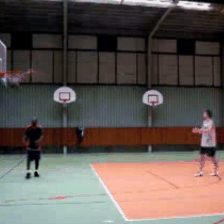

In [12]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """
    Un-normalizes the image pixels
    """
    img=(img*std)+mean
    img=(img*255).astype("uint8")
    return img.clip(0,255)
    
    
def create_gif(video_tensor, filename="sample.gif"):
    """
    Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames=[]
    for video_frame in video_tensor:
        frame_unnormalized=unnormalize_img(video_frame.permute(1,2,0).numpy())
        frames.append(frame_unnormalized)
    kargs={"duration":0.25}
    imageio.mimsave(filename, frames, "GIF",**kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor"""
    video_tensor=video_tensor.permute(1,0,2,3)
    gif_filename=create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


sample_video=next(iter(train_dataset))
video_tensor=sample_video["video"]
display_gif(video_tensor)

# Training

In [13]:
# The dataset returned by Ucf101() doesn't implement the `__len__` method.
# As such, we must define `max_steps` when instantiating TrainingArguments
batch_size=2
num_epochs=1
max_steps=(train_dataset.num_videos//batch_size)*num_epochs

print(max_steps)

150


We need to define a function to compute the metrics from the predictions, which will use the metric we will load now. The only preprocessing you have to do is to take the argmax of our predicted logits:

In [14]:
import evaluate
import torch

metric=evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions=np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values=torch.stack(
        [example["video"].permute(1,0,2,3) for example in examples]
    )
    
    labels=torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
from transformers import TrainingArguments, Trainer

training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=max_steps,
    fp16=True,
    report_to="wandb",
    run_name=os.getenv("WANDB_NAME"),
)

trainer=Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240229_122527-9fy70x4b
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-videomae-ucf101
wandb: ⭐️ View project at https://wandb.ai/causal_language_trainer/Fine-tune%20videomae%20on%20ucf101
wandb: 🚀 View run at https://wandb.ai/causal_language_trainer/Fine-tune%20videomae%20on%20ucf101/runs/9fy70x4b
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
0,0.251900,0.149788,1.000000
1,0.074600,0.027767,1.000000


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/

TrainOutput(global_step=150, training_loss=0.5542592459917068, metrics={'train_runtime': 444.2468, 'train_samples_per_second': 1.351, 'train_steps_per_second': 0.338, 'total_flos': 7.47692094062592e+17, 'train_loss': 0.5542592459917068, 'epoch': 1.5})

In [16]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.14978763461112976,
 'eval_accuracy': 1.0,
 'eval_runtime': 21.034,
 'eval_samples_per_second': 3.328,
 'eval_steps_per_second': 0.856,
 'epoch': 1.5}

In [17]:
kwargs={
    'model_name': os.getenv('WANDB_NAME'),
    'finetuned_from': 'MCG-NJU/videomae-base-finetuned-kinetics',
    'tasks': 'Video Classification',
#     'dataset_tags':'',
    'dataset':'aisuko/funsd-layoutlmv3'
}

image_processor.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(**kwargs)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

'https://huggingface.co/aisuko/ft-videomae-ucf101/tree/main/'

# Inference

In [18]:
sample_test_video=next(iter(test_dataset))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The simplest way to try out fine-tuned model for inference is to use it in a pipeline.

In [19]:
from transformers import pipeline

video_cls=pipeline(task="video-classification", model="aisuko/"+os.getenv("WANDB_NAME"), device="cuda")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

In [20]:
video_cls("https://huggingface.co/datasets/sayakpaul/ucf101-subset/resolve/main/v_BasketballDunk_g14_c06.avi")

/opt/conda/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(value)


[{'score': 0.8388357162475586, 'label': 'BasketballDunk'},
 {'score': 0.07670807838439941, 'label': 'Basketball'},
 {'score': 0.01735062152147293, 'label': 'BandMarching'},
 {'score': 0.015664374455809593, 'label': 'BabyCrawling'},
 {'score': 0.015290667302906513, 'label': 'BaseballPitch'}]

# By Manually

In [21]:
def run_inference(model, video):
    perumuted_sample_test_video=video.permute(1,0,2,3)
    inputs={
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ), # this can be skipped if we don't have labels avaliable
    }
    
    device="cuda"
    inputs={k:v.to(device) for k,v in inputs.items()}
    model=model.to(device)
    
    # forward pass
    with torch.no_grad():
        outputs=model(**inputs)
        logits=outputs.logits
    
    return logits

In [22]:
model = VideoMAEForVideoClassification.from_pretrained(os.getenv("WANDB_NAME"))

logits=run_inference(model, sample_test_video["video"])

In [23]:
# decoding the logits
predicted_class_idx=logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BasketballDunk
